# Урок 5. Случайный лес. Домашнее задание

Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

(На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.


In [700]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np
import pandas as pd

In [701]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_samples=100,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=23)

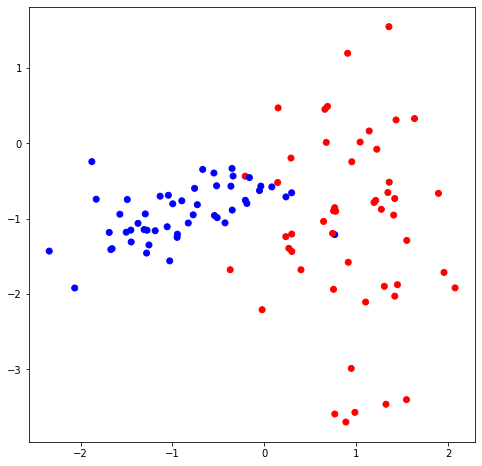

In [702]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [703]:
np.random.seed(20)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        test_index = np.array([el for el in range(data.shape[0]) if el not in list(sample_index)])
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        test_data = data[test_index]
        test_labels = labels[test_index]
        
        bootstrap.append((b_data, b_labels, test_data, test_labels, test_index))
        
    return bootstrap

In [704]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.round(np.sqrt(len_sample)))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [705]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [706]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [707]:
# Расчет критерия энтропии Шеннона 

def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p*np.log2(p)
        
    return impurity

In [708]:
# Расчет прироста

def gain(left_labels, right_labels, root_entropy):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_entropy - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)

In [709]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [710]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_entropy = calc_entropy(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [711]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [712]:
def random_forest(data, labels, n_trees):
    forest = []
    test_list = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for i in range(len(bootstrap)):
        forest.append(build_tree(bootstrap[i][0], bootstrap[i][1]))
        
    return forest

In [713]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    

In [714]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [715]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [716]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [717]:
def oob(bootstrap, forest):
    predictions_test = []
    test_indexes = []
    test_labels = []
    for i in range(len(forest)):
        predictions_test = predictions_test + list(predict(bootstrap[i][2], forest[i]))
        test_indexes = test_indexes + list(bootstrap[i][4])
        test_labels = test_labels + list(bootstrap[i][3])
    test_df = pd.DataFrame(data=test_indexes, columns=['obj_index'])
    test_df['test_prediction'] = np.array(predictions_test)
    test_df['test_labels'] = np.array(test_labels)
    test_df_mean = test_df.groupby(['obj_index', 'test_labels']).agg({'test_prediction': 'mean'}).reset_index()
    test_df_mean['test_prediction'] = test_df_mean['test_prediction'].round()
    return accuracy_metric(test_df_mean['test_labels'], test_df_mean['test_prediction'])

Обучим случайный лес из 1, 3, 10 и 50 деревьев и визуализируем их разделяющие гиперплоскости на графиках. Также выведем значение acuracy на тренировочных данных и OOB acuracy.

In [718]:
trees_list = [1,3,10,50]

In [719]:
#функция для построения графика разделяющей гиперплоскости
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

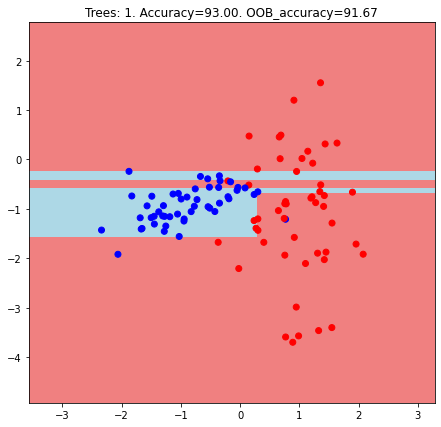

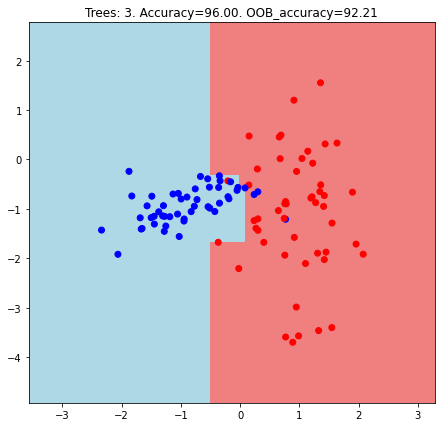

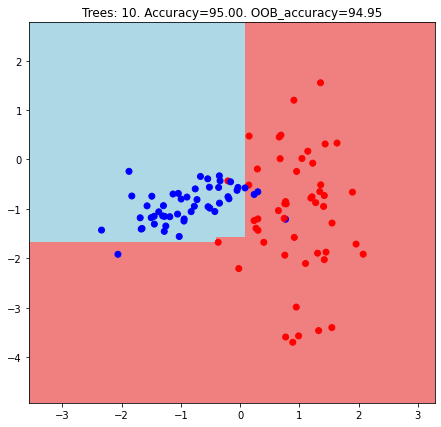

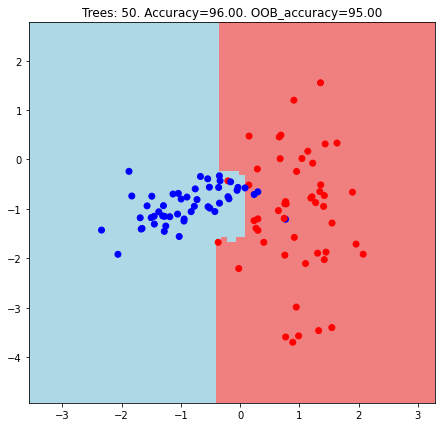

In [722]:
answers_list = []
for trees_n in trees_list:
    my_forest = random_forest(classification_data, classification_labels, trees_n)
    oob_accuracy = oob(get_bootstrap(classification_data, classification_labels, trees_n), my_forest)
    answers = tree_vote(my_forest, classification_data)
    answers_list.append(answers) #запишем результаты в список
    accuracy = accuracy_metric(classification_labels, answers)
    # Визуализируем дерево на графике
    
    # график обучающей выборки
    plt.figure(figsize = (16, 7))
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(classification_data)
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    mesh_predictions = np.array(tree_vote(my_forest, mesh_data)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(classification_data[:, 0], classification_data[:, 1], c = classification_labels, cmap = colors)
    plt.title(f'Trees: {trees_n}. Accuracy={accuracy:.2f}. OOB_accuracy={oob_accuracy:.2f}')

Cложность гиперплоскости возрастает с ростом количества деревьев. Accuracy возрастает с ростом количества деревьев, количество деревьев 50 дает accuracy 96% (при этом OOB accuracy 95%), если показатель минимального количества экземпляров в листе равен 5. Если этот показатель не ограничен (т.е.равен 1 объекту), accuracy на тренировочных данных доходит до 100% и модель переобучается. С ростом количества деревьев accuracy на трейне и OOB accuracy становятся очень близкими по значению, следовательно, модель обучается хорошо. Необходимо увеличивать количество деревьев в ансамбле, но до тех пор, пока модель не начнет переобучаться, т.е. следить за метриками на тренировочных и тестовых (или тестовых OOB) данных. В нашем примере можно было ограничиться 10 деревьями, показатели на них уже достаточные.